在这一节中，我们将从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器。

In [3]:
%matplotlib inline
import random
from mxnet import autograd, np, npx
from d2l import mxnet as d2l

## 3.2.1 生成数据集

根据带有噪声的线性模型，来构造一个人造数据集，任务是使用这个有限样本的数据集来 `恢复` 这个模型的 `参数` 。

生成一个包含1000个样本的数据集，每个样本包含从标准正态分布中采样的2个特征。我们的合成数据集是一个矩阵 $\mathbf{X} \in \mathbb{R}^{1000 \times 2}$.

使用线性模型参数 $\mathbf{w} = [2, -3.4]$、$b = 4.2$和噪声项 $\epsilon$ 生成数据集及其标签：
$$
\mathbf{y} = \mathbf{X} \mathbf{w} + b + \epsilon
$$

$\epsilon$ 可以视为模型预测和标签时的潜在观测误差。假设 $\epsilon$ 服从均值为0，标准差为0.01的正态分布。

In [5]:
def synthetic_data(w, b, num_examples): #@save
    """生成y=Xw+b+噪声"""
    X = np.random.normal(0, 1, (num_examples, len(w)))
    y = np.dot(X, w) + b
    y += np.random.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [6]:
true_w = np.array([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

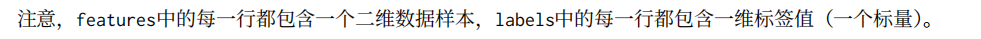

In [7]:
print('features:', features[0], '\nlabels', labels[0])

features: [2.2122064 1.1630787] 
labels [4.662078]


通过生成第二个特征features[:, 1]和labels的散点图，可以直观观察到两者的线性关系。

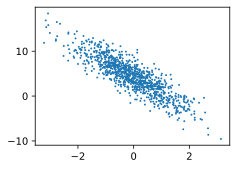

In [10]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].asnumpy(), labels.asnumpy(), 1);

## 3.2.2 读取数据集

定义一个函数，这个函数可以打乱数据集中的样本并以小批量方式获取数据。

在下面的代码中，我们定义一个data_iter函数，该函数接受批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。每个小批量包含一组特征和标签。

In [11]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 随机读取样本，没有顺序
    random.shuffle(indices)
    # 这里的batch_size是步长
    for i in range(0, num_examples, batch_size): 
        batch_indices = np.array(
            indices[i: min(i + batch_size, num_examples)]
        )
        yield features[batch_indices], labels[batch_indices]

读取第一个小批量数据样本并打印。每个批量的特征维度显示批量大小和输入特征数。同样的，批量的标签性形状与batch_size相等。

In [12]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

[[ 0.07713585 -0.7471699 ]
 [-0.6015945   0.29670078]
 [-0.07620197 -0.53280455]
 [ 0.34593368 -0.7567092 ]
 [ 1.2390957   2.173063  ]
 [-1.0348833   0.11296888]
 [-0.01124159  0.6532863 ]
 [-0.51905143 -2.067554  ]
 [ 3.2904532   0.13123234]
 [ 0.51062024 -0.34078157]] 
 [[ 6.8940077]
 [ 1.9725974]
 [ 5.8847575]
 [ 7.478742 ]
 [-0.7127881]
 [ 1.7331711]
 [ 1.9496151]
 [10.181485 ]
 [10.31914  ]
 [ 6.384293 ]]


## 3.2.3 初始化模型参数

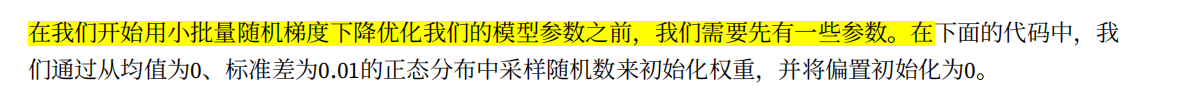

In [14]:
w = np.random.normal(0, 0.01, (2, 1))
b = np.zeros(1)
w.attach_grad() # 计算和储存w的梯度
b.attach_grad()

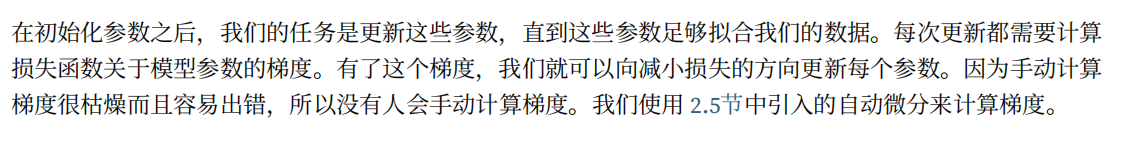

## 3.2.4 定义模型
将模型的输入和参数同模型的输出关联起来。

注意 $\mathbf{Xw}$ 是一个向量，而 $b$ 是一个标量，而 `广播机制` ：当用一个向量加一个标量时，标量会被加到向量的每个分量上。

In [15]:
def linreg(X, w, b): #@save
    """线性回归模型"""
    return np.dot(X, w) + b

## 3.2.5 定义损失函数

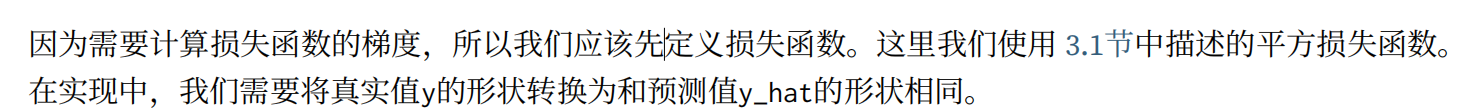

In [16]:
def squared_loss(y_hat, y): #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 3.2.6 定义优化算法
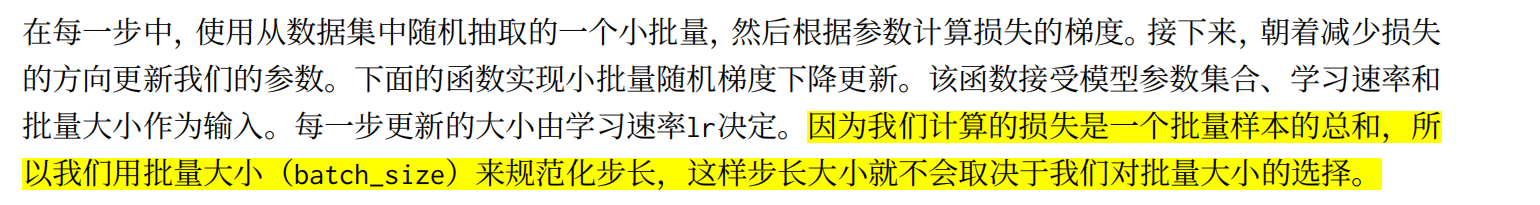

In [17]:
def sgd(params, lr, batch_size): #@save
    """小批量随机梯度下降"""
    for param in params:
        param[:] = param - lr * param.grad / batch_size

## 3.2.7 训练

理解这段代码至关重要，因为从事深度学习后，相同的训练过程几乎一遍又一遍地出现。

在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。计算完损失后，我们开始反向传播，存储每个参数的梯度。最后我们调用优化算法 `sgd` 来更新模型参数。

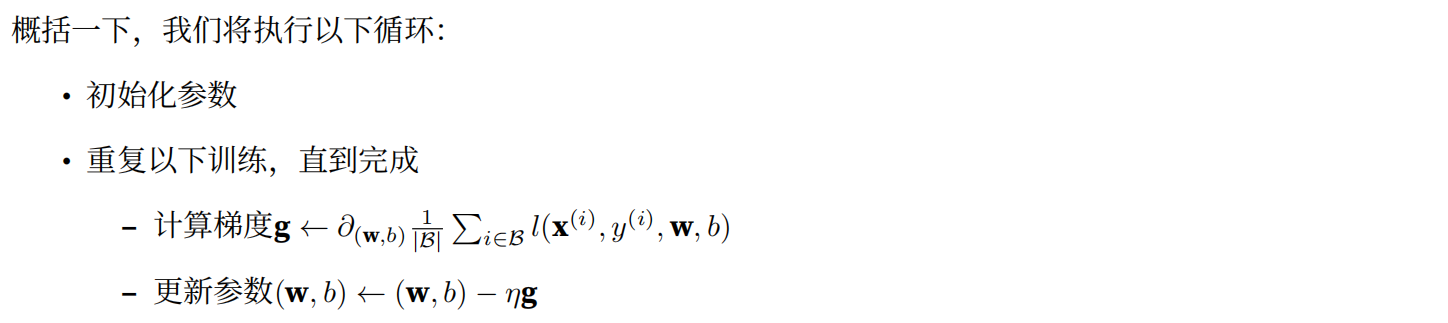

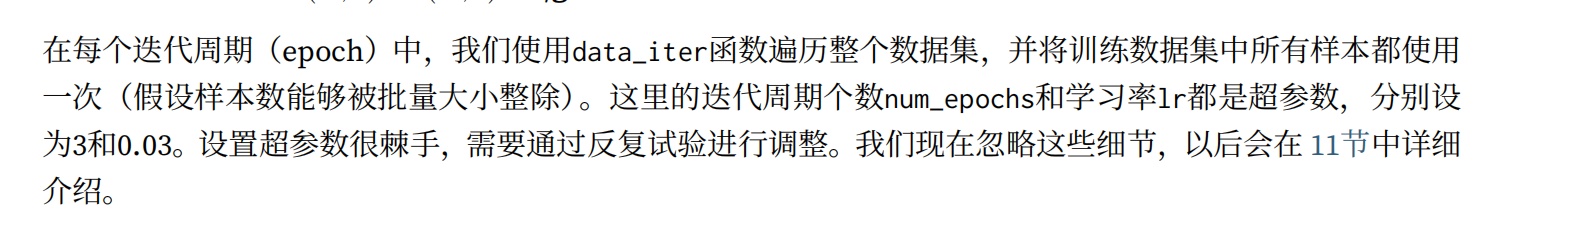

In [26]:
lr = 0.001
num_epochs = 3
net = linreg
loss = squared_loss

In [27]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y) # X和y的小批量损失
        # 计算l关于[w,b]的梯度
        l.backward()
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新参数
    train_1 = loss(net(features, w, b), labels)
    print(f'epoch{epoch + 1}. loss{float(train_1.mean()):f}')

epoch1. loss0.000054
epoch2. loss0.000053
epoch3. loss0.000053


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [28]:
print(f'w的估计误差: {abs(true_w - w.reshape(true_w.shape))}')
print(f'b的估计误差: {abs(true_b - b)}')

w的估计误差: [0.00166607 0.00027537]
b的估计误差: [0.00014496]
